In [1]:
# import basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import self-defined modules
from implementations import *
from tools import *
from helpers import *

# just to ingore warning
import warnings
warnings.filterwarnings('ignore')

# Pre-processing before modeling

## 1. Load Training Data

In [2]:
# load train and test data
data_path_tr = 'data/train.csv'
yb_tr, data_tr, idx_tr, labels = load_csv_data(data_path_tr, sub_sample=False)

# prepare the data using self-defined DataFrame class
labels_dataframe = ['Prediction'] + labels
data_tr_dataframe = np.concatenate((yb_tr.reshape([-1, 1]), data_tr), axis=1)
dataframe_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)

## 2. Data Analysis and Pre-processing

Without any data processing and feature selection, we can see that the model prediction is not doing very well.

In [3]:
regression_method = ridge_regression
lambda_ = 0.001
seed = 10
k_fold = 10

raw_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)
x = raw_tr.drop('Prediction').values
y = raw_tr['Prediction']
w_raw,acc_tr_raw,acc_te_raw = cv_loop(y, x, k_fold, seed, regression_method,lambda_=lambda_)
acc_te_raw

0.7439920000000001

### 2.1 Missing Values Replacement

As described in the document, we knew that there are '-999' referring to missing or undefined data. Before further processing, we needed to deal with these abnormal data.

What's worth noticing was that there were 10 features related to the value of jet_num. If jet_num = 0 or 1, these features would be undefined and we did not need to replace -999 in these features. Then, we needed to find columns with missing data and replace the missing values with mode of the feature.

So, at first we should calculate missing rate in each feature to find out the columns that need to be replaced.

In [4]:
# calculate missing rate 
def missing_rate(dataframe, miss_number = -999):
    features = dataframe.drop(['Prediction'])
    missing_rate = []
    for feature in features.labels:
        data = features.loc(features[feature] ==  miss_number)
        if data.values.size != 0:
            missing_rate.append(data[feature].size / features[feature].size)
        else:
            missing_rate.append(0)
    missing_rate = np.array(missing_rate).reshape([1, -1]).squeeze()
    missing_rate_labels = dataframe.labels[1:]
    return DataFrame(missing_rate, [0], missing_rate_labels)

In [5]:
miss_rate = missing_rate(dataframe_tr)
miss_rate.values

array([0.152456, 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.399652,
       0.399652, 0.399652, 0.709828, 0.709828, 0.709828, 0.      ])

In [6]:
miss_rate.labels[0]

'DER_mass_MMC'

There were 11 features with -999 and 10 of them had very high missing rate. According to the Higgs Boson document, we can know that the high missing rate of these 10 features were due to values of jet_num, and they were not defined on -999 and should not be replaced. 

So now there was only the first feature, namely 'DER_mass_MMC', left to be replaced. And here, we separately calculated the mode of DER_mass_MMC in signal and background and replaced -999 with the mode.

In [7]:
# # calculate mode of 'DER_mass_MMC' in signal
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==1)
# DER_mode_s = temp.value_counts('DER_mass_MMC').index[0]

# # calculate mode of 'DER_mass_MMC' in background
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==-1)
# DER_mode_b = temp.value_counts('DER_mass_MMC').index[0]      

DER_mode_s =119.89 # calculated from above 
DER_mode_b =96.819

# replace -999（undefined values of 'DER_mass_MMC'） with mode respectively
temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_s

temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==-1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_b

### 2.2 Feature charatistics by histogram

To observe the charateristics of 30 features, we drew the histogram(without -999) to show their distribution.

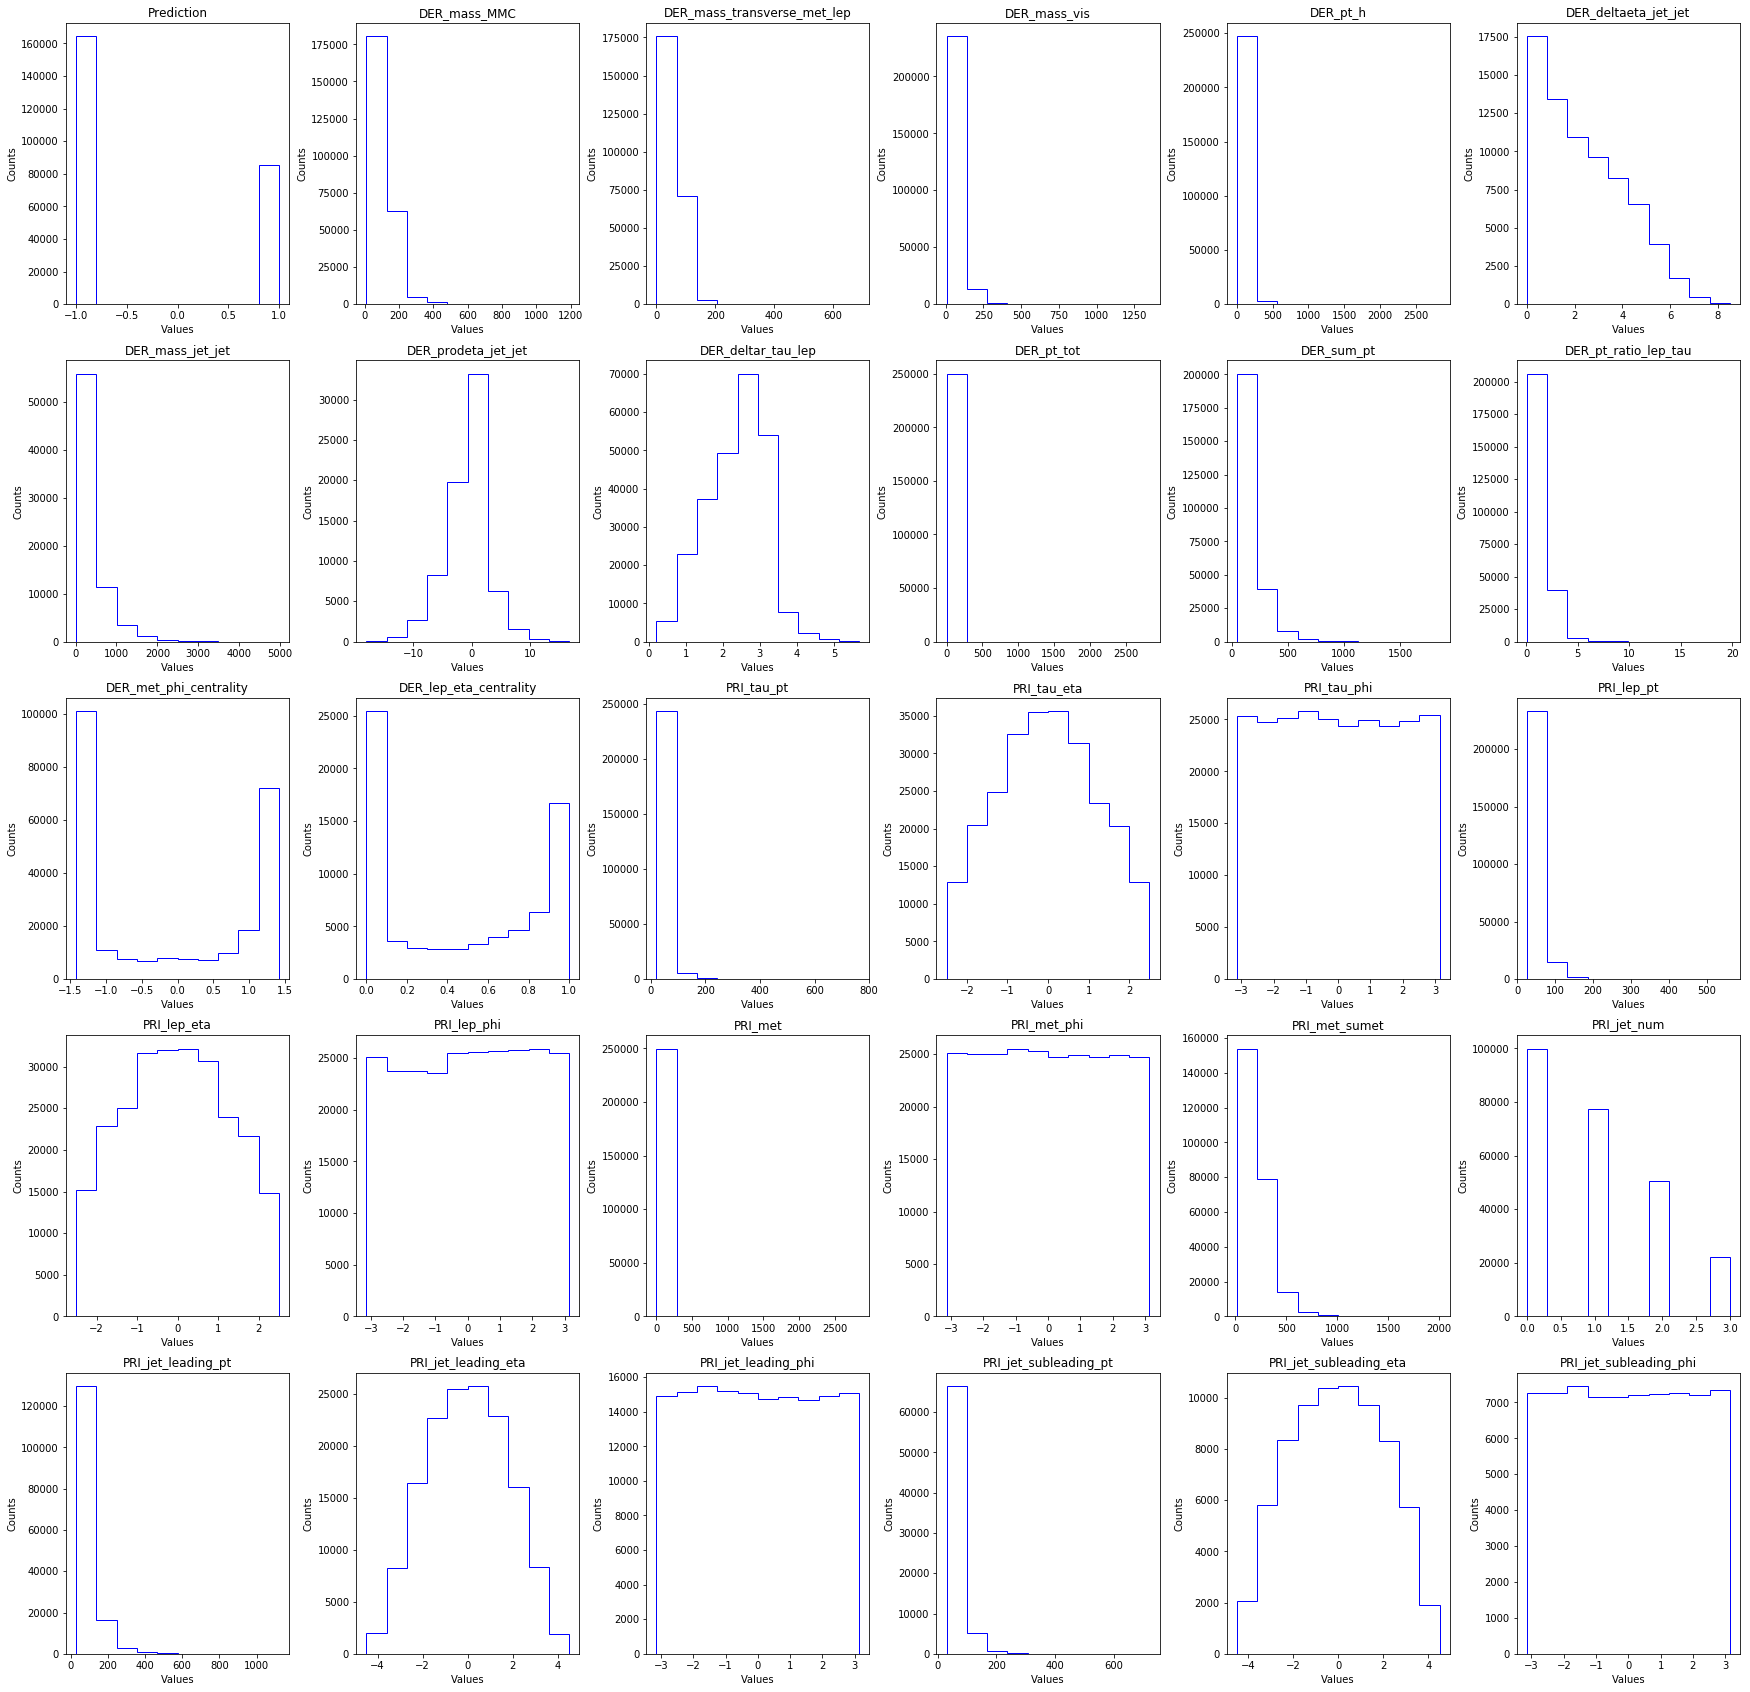

In [8]:
# plot histogram of each feature
figure, axes = plt.subplots(5, 6, facecolor='white', figsize=(30, 30))
figure.subplots_adjust(wspace=0.3)
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr.values[:, index]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype='step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(dataframe_tr.labels[index])

And we noticed that there are five feature with uniform distribution. After discussion, we thought that such features can somewhat be considered like white noise, which is also uniformly distributed and does not provide useful information. Hence, we droped these five feature.

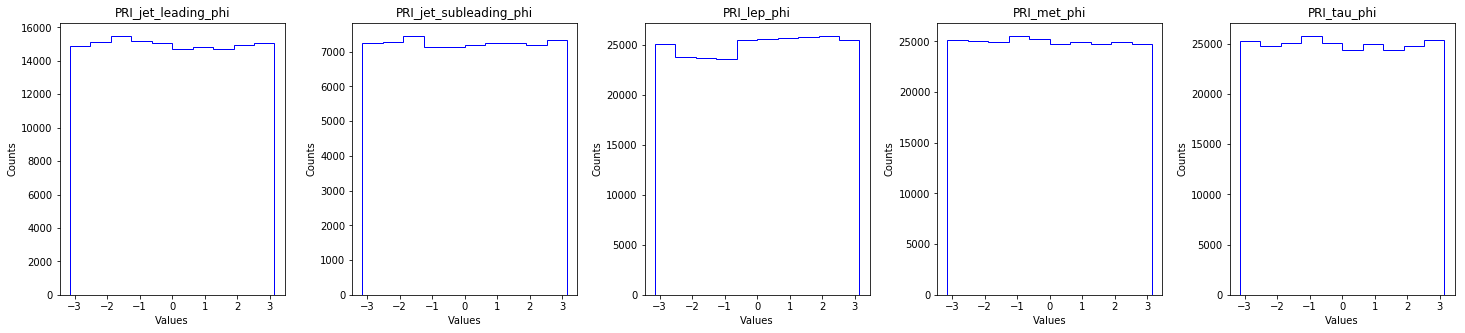

In [9]:
# select feature uniformly distributed and show them
feature_dorp_phi = ['PRI_jet_leading_phi',
                    'PRI_jet_subleading_phi',
                    'PRI_lep_phi',
                    'PRI_met_phi',
                    'PRI_tau_phi']

# figure, axes = plt.subplots(2, round(len(feature_dorp_phi)/2), facecolor='white', figsize=(30, 7))
figure, axes = plt.subplots(1, 5, facecolor='white', figsize=(25, 5))
axes = axes.ravel()
figure.subplots_adjust(wspace=0.3)
for index, axes_index in enumerate(axes):
    column = dataframe_tr[feature_dorp_phi[index]]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype= 'step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(feature_dorp_phi[index])
# figure.savefig('features.jpg')

In [10]:
# drop features which are uniformly distributed
dataframe_tr = dataframe_tr.drop(feature_dorp_phi)

### 2.3 Data grouping by PRI_jet_num

According to the Higgs Boson document, when PRI_jet_num = 0,1, seven features , namely 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta' and 'PRI_jet_subleading_phi' would be undefined.

And when PRI_jet_num = 0, three features, namely 'PRI_jet_leading_pt', 'PRI_jet_leading_eta' and 'PRI_jet_leading_phi' would be undefined.

So it's necessary to group data into three parts and drop undefined features in each group.

Here we first grouped data by PRI_jet_num, feature dropping would be implemented in later part.

In [11]:
def group_features_by_jet(dataframe):
    """
    The function is used to divide training data to 3 groups according to feature 'PRI_jet_num'.
    
    Input:
        dataframe: 
        The self-defined dataframe containing features and data.
        
    Return:
        Return a dictonary containing three self-defined dataframe after grouping.
    """
    return {  
        0: dataframe.loc( dataframe['PRI_jet_num'] == 0).copy(),
        1: dataframe.loc( dataframe['PRI_jet_num'] == 1).copy(),
        2: dataframe.loc((dataframe['PRI_jet_num'] == 2) | (dataframe['PRI_jet_num'] == 3)).copy(),
    }
dataframe_tr_grp = group_features_by_jet(dataframe_tr)

### 2.4 Feature Selection

#### 2.4.1 Undefined features in each jet_num group

As mentioned above, here we droped undefined features in each jet_num group.

In [12]:
# get features with undefined values (features whose missing rate of -999 are 100%)
dataframe_tr_feature_undefined = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], -999)
    dataframe_tr_feature_undefined.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())

In [13]:
# display those features with undefined values in each group
dataframe_tr_feature_undefined[0]

['DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta']

In [14]:
dataframe_tr_feature_undefined[1]

['DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta']

In [15]:
dataframe_tr_feature_undefined[2]

[]

In [16]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_undefined[0])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(dataframe_tr_feature_undefined[1])
# group2 have no feature with undefined values

#### 2.4.2 All zeros columns and PRI_jet_num column

After grouping we noticed that in group one 'PRI_jet_all_pt' was all zeros. Also, 'PRI_jet_num' no longer offered more information and we needed to drop them.

In [17]:
# calculate print column name with all zeros
for i in range(len(dataframe_tr_grp)):
    df_tr_miss = missing_rate(dataframe_tr_grp[i], 0)
    print(np.array(df_tr_miss.labels)[df_tr_miss.values == 1])

['PRI_jet_num' 'PRI_jet_all_pt']
[]
[]


In [18]:
# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(['PRI_jet_num', 'PRI_jet_all_pt'])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

#### 2.4.3 Linear correlated features

Under the assumption that strong linear-related features will be redundant, we plan to drop these features, too. However, in later validating part, we find out that dropping these features do not help improve the model performance. On the contrary, it drawbacks a little.

Here we show how we choose these linear-correlated features and will test them in later part.

In [20]:
def corr(df, threshold):
    """
    The function is used to calculate correlation efficients between each feature.
    
    Inputs:
        df: 
        The self-defined dataframe containing features and data.
        
        threshold:
        The threshold used to filter strong correlated features.
        
    Return:
        corr_list:
        List containing features in strong correlation.
    """
    corr = np.corrcoef(df.values.T)
    corr_list = []
    temp = np.array(df.labels)
    for i in range(corr.shape[0]):
        same_flag = []
        corr_coeff = temp[(corr[i] > threshold) | (corr[i] < -threshold)]
        corr_coeff = corr_coeff.tolist()
        if len(corr_coeff) > 1 and len(corr_list) != 0:
            for corr_term in corr_list:   # delete the same feature combinations
                judge_1 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_term))
                judge_2 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_coeff))
                same_flag.append(judge_1 | judge_2)
            if sum(same_flag) == 0:
                corr_list.append(corr_coeff)
        elif len(corr_coeff) > 1:
            corr_list.append(corr_coeff)
    return corr_list

# get feature combinations whose linear correlation coefficient larger than the threshold
threshold_tr = 0.7
corr_grp0 = corr(dataframe_tr_grp[0], threshold_tr)
corr_grp1 = corr(dataframe_tr_grp[1], threshold_tr)
corr_grp2 = corr(dataframe_tr_grp[2], threshold_tr)

In [21]:
# display those feature combinations of each group 
corr_grp0

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_pt_tot'],
 ['DER_sum_pt', 'PRI_tau_pt', 'PRI_lep_pt']]

In [22]:
corr_grp1

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [23]:
corr_grp2

[['DER_mass_MMC', 'DER_mass_vis'],
 ['DER_pt_h', 'DER_sum_pt', 'PRI_met', 'PRI_jet_leading_pt'],
 ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet'],
 ['DER_pt_h',
  'DER_sum_pt',
  'PRI_met_sumet',
  'PRI_jet_leading_pt',
  'PRI_jet_subleading_pt',
  'PRI_jet_all_pt'],
 ['DER_pt_ratio_lep_tau', 'PRI_lep_pt']]

In [24]:
# drop features with strong linear correlation
feature_dorp_corr0 = list(['DER_mass_MMC','DER_pt_tot','PRI_tau_pt','PRI_lep_pt'])
feature_dorp_corr1 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])
feature_dorp_corr2 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])

# name the data without correlation features as df_tr_grp
df_tr_grp_dpcorr = dataframe_tr_grp.copy()
df_tr_grp_dpcorr[0] = df_tr_grp_dpcorr[0].drop(feature_dorp_corr0)
df_tr_grp_dpcorr[1] = df_tr_grp_dpcorr[1].drop(feature_dorp_corr1)
df_tr_grp_dpcorr[2] = df_tr_grp_dpcorr[2].drop(feature_dorp_corr2)

### 2.5 Data processing

In this part we will show methods to do data processing and how they improve the model performance. For brief illustration, we simply use ridge regression with lambda = 0.001, and calculate the accuracy on dataframe_tr_grp[0], and compare the changes.

In [28]:
k_fold = 10
seed = 10
regression_method = ridge_regression
lambda_= 0.001

x = dataframe_tr_grp[0].drop('Prediction').values
y = dataframe_tr_grp[0]['Prediction']

In [29]:
_,acc_tr_nopr,acc_te_nopr = cv_loop(y, x, k_fold, seed, regression_method, lambda_ = lambda_)
print('The 10-fold average accuracy on test set without data process is: '+str(acc_te_nopr))

The 10-fold average accuracy on test set without data process is: 0.8101491342207987


In [30]:
x_log = log_process(x)
_,acc_tr_logpr,acc_te_logpr = cv_loop(y, x_log, k_fold, seed, regression_method, lambda_ = lambda_)
print('The 10-fold average accuracy on test set using logrithm data is: '+str(acc_te_logpr))

The 10-fold average accuracy on test set using logrithm data is: 0.8184866379741769


In [31]:
x_stand,_,_ = standardize(x_log)
x_poly = build_poly(x_stand, degrees = 11)
_,acc_tr_poly,acc_te_poly = cv_loop(y, x_poly, k_fold, seed, regression_method, lambda_ = lambda_)
print('The 10-fold average accuracy on test set using polynomial data is: '+str(acc_te_poly))

The 10-fold average accuracy on test set using polynomial data is: 0.8529876889200281


As shown above, the method of logrithm and polynomial can improve the prediction performance. Thus, we choose use these method to process our data before model training.

In [32]:
def data_processing(data, degrees):
    """
    The function is used to process raw data with taking logrithm, standardization and polynomial.
    
    Inputs:
        data:
        The numpy.array containing raw data.
        
        degrees:
        The degree for polynomial features.
        
    Result:
        Processed data in numpy.array.
    """
    data = log_process(data)           # logrithm narrows the range of data value
    data, _, _ = standardize(data)     # standardize data
    data_poly = build_poly(data, degrees)     # build polynominal data
    return data_poly                  

And we extract the values from the self-defined dataframe and save them into data_tr_grp and predict_tr_grp as lists of numpy array. This step will make following data processing more convenient.

In [33]:
data_tr_grp = []     # store the data values of each group
pred_tr_grp = []     # store the prediction labels of each group
for index in range(len(dataframe_tr_grp)):
    data_tr_grp.append(dataframe_tr_grp[index].drop('Prediction').values)
    pred_tr_grp.append((dataframe_tr_grp[index])['Prediction'])

# Model Selection

In this part, we compared the performance of different models and chose the best one to create Kaggle output. And we also included `Hyper parameter Tuning Using Grid Search` for parameter tuning in following part.

We here just picked the data where jet_num = 0 as the data set, used 10-fold cross validation to validate the performance of each model.

In [35]:
x = dataframe_tr_grp[0].drop('Prediction').values

y = dataframe_tr_grp[0]['Prediction']
y = y.reshape(len(y),1)
k_fold = 10
seed = 10

### Least squares

In [45]:
# least squares
regression_method = least_squares
acc_tr_ls = np.zeros((6,1))
acc_te_ls = np.zeros((6,1))
degrees = [1,3,5,7,9]

w_ls,acc_tr_ls[0],acc_te_ls[0] = cv_loop(y, x, k_fold, seed, regression_method)
print("Degree: 0, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(acc_tr=acc_tr_ls[0], acc_te=acc_te_ls[0]))

for i in range(len(degrees)):
    tx = data_processing(x,degrees[i])
    w_ls,acc_tr_ls[i+1],acc_te_ls[i+1] = cv_loop(y, tx, k_fold, seed, regression_method)
    print("Degree: {deg}, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(deg=str(degrees[i]),acc_tr=acc_tr_ls[i+1], acc_te=acc_te_ls[i+1]))



Degree: 0, the 10-fold average train accuracy = [0.81044683], test accuracy=[0.8106696]
Degree: 1, the 10-fold average train accuracy = [0.84527257], test accuracy=[0.84454009]
Degree: 3, the 10-fold average train accuracy = [0.84659038], test accuracy=[0.84590131]
Degree: 5, the 10-fold average train accuracy = [0.84419497], test accuracy=[0.84351917]
Degree: 7, the 10-fold average train accuracy = [0.847698], test accuracy=[0.84652187]
Degree: 9, the 10-fold average train accuracy = [0.81741398], test accuracy=[0.81608448]


### Ridge regression

In [36]:
# ridge regression
lambda_ = 0.001
regression_method = ridge_regression
acc_tr_rid = np.zeros((6,1))
acc_te_rid = np.zeros((6,1))
w_rid,acc_tr_rid[0],acc_te_rid[0] = cv_loop(y, x, k_fold, seed, regression_method,lambda_=lambda_)
print("Degree: 0, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(acc_tr=acc_tr_rid[0], 
                                                                                                acc_te=acc_te_rid[0]))

degrees = [1,3,5,7,9]

for i in range(len(degrees)):
    tx = data_processing(x,degrees[i])
    w_rid,acc_tr_rid[i+1],acc_te_rid[i+1] = cv_loop(y, tx, k_fold, seed, regression_method,lambda_=lambda_)
    print("Degree: {deg}, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(deg=str(degrees[i]),
                                                                                                        acc_tr=acc_tr_rid[i+1], acc_te=acc_te_rid[i+1]))


Degree: 0, the 10-fold average train accuracy = [0.81015102], test accuracy=[0.81014913]
Degree: 1, the 10-fold average train accuracy = [0.85134116], test accuracy=[0.85101591]
Degree: 3, the 10-fold average train accuracy = [0.85227197], test accuracy=[0.85152637]
Degree: 5, the 10-fold average train accuracy = [0.85333845], test accuracy=[0.85252727]
Degree: 7, the 10-fold average train accuracy = [0.8545862], test accuracy=[0.85382845]
Degree: 9, the 10-fold average train accuracy = [0.85526345], test accuracy=[0.8545591]


For logistic regression, the most important parameter is the step size gamma. Here we set the gamma = 1/max(eignvalue of x.T.dot(x)), which was the best gamma theoretically. Due to the pour computing ability of our laptop, we set max iteration times = 1000 and accelerated by multiplying gamma by 5.

### Logistic regression

In [52]:
# logistic regression 
regression_method = logistic_regression

w_init = np.zeros([x.shape[1], 1])

acc_tr_log = np.zeros((6,1))
acc_te_log = np.zeros((6,1))

eignvalue, _ = np.linalg.eig(x.T.dot(x))
gamma = 1 / (0.5 * eignvalue.max())*5
gamma = gamma.real

w_log,acc_tr_log[0],acc_te_log[0] = cv_loop(y, x, k_fold, seed, regression_method,initial_w=w_init, max_iters=3000,gamma = gamma)
print("Degree 0: the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(acc_tr=acc_tr_log[0], acc_te=acc_te_log[0]))

degrees = [1,3,5,7,9]

for i in range(len(degrees)):
    
    tx = data_processing(x,degrees[i])
    eignvalue, _ = np.linalg.eig(tx.T.dot(tx))
    gamma = 1 / (0.5 * eignvalue.max())*5
    gamma = gamma.real
    w_init = np.zeros([tx.shape[1], 1])
    w_log,acc_tr_log[i+1],acc_te_log[i+1] = cv_loop(y, tx, k_fold, seed, regression_method,initial_w=w_init, max_iters=3000,gamma = gamma)
    print("Degree: {deg}, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(deg=str(degrees[i]),
                                                                                                        acc_tr=acc_tr_log[i+1], acc_te=acc_te_log[i+1]))


Degree 0: the 10-fold average train accuracy = [0.80769333], test accuracy=[0.80739666]
Degree: 1, the 10-fold average train accuracy = [0.84241565], test accuracy=[0.84223801]
Degree: 3, the 10-fold average train accuracy = [0.77566669], test accuracy=[0.77569813]
Degree: 5, the 10-fold average train accuracy = [0.4386535], test accuracy=[0.43870483]
Degree: 7, the 10-fold average train accuracy = [0.48811081], test accuracy=[0.48819938]
Degree: 9, the 10-fold average train accuracy = [0.49188408], test accuracy=[0.49184266]


### Regularized logistic regression

In [53]:
# regularized logistic regression
regression_method = reg_logistic_regression

acc_tr_reg = np.zeros((6,1))
acc_te_reg = np.zeros((6,1))

eignvalue, _ = np.linalg.eig(x.T.dot(x))
gamma = 1 / (0.5 * eignvalue.max())*5
gamma = gamma.real
w_init = np.zeros([x.shape[1], 1])

w_reg,acc_tr_reg[0],acc_te_reg[0] = cv_loop(y, x, k_fold, seed, regression_method,initial_w=w_init, max_iters=3000,gamma = gamma,lambda_=0.001)
print("Degree 0: the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(acc_tr=acc_tr_reg[0], acc_te=acc_te_reg[0]))

degrees = [1,3,5,7,9]

for i in range(len(degrees)):
    
    tx = data_processing(x,degrees[i])
    eignvalue, _ = np.linalg.eig(tx.T.dot(tx))
    gamma = 1 / (0.5 * eignvalue.max())*5
    gamma = gamma.real
    w_init = np.zeros([tx.shape[1], 1])
    w_reg,acc_tr_reg[i+1],acc_te_reg[i+1] = cv_loop(y, tx, k_fold, seed, regression_method,initial_w=w_init, max_iters=3000,gamma = gamma,lambda_=0.001)
    print("Degree: {deg}, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(deg=str(degrees[i]),
                                                                                                        acc_tr=acc_tr_reg[i+1], acc_te=acc_te_reg[i+1]))



Degree 0: the 10-fold average train accuracy = [0.80742532], test accuracy=[0.80739666]
Degree: 1, the 10-fold average train accuracy = [0.83542181], test accuracy=[0.83538184]
Degree: 3, the 10-fold average train accuracy = [0.77580459], test accuracy=[0.77569813]
Degree: 5, the 10-fold average train accuracy = [0.44823069], test accuracy=[0.44819337]
Degree: 7, the 10-fold average train accuracy = [0.47823336], test accuracy=[0.47761986]
Degree: 9, the 10-fold average train accuracy = [0.48024621], test accuracy=[0.47970173]


We could see that least square seems to perform very good both on traning set and test set. However, if we applied least square on test.csv and uploaded the result to Kaggle, the score was really low (only 0.51944), implying that least square in risk of overfitting. 

Ridge regression added lambda as penalty to avoid overfitting and we could see that when lambda = 0.001, ridge regression also had a good performance, and on Kaggle we got a score on 0.82236 for this model, showing that ridge regression balanced well between improving model accuracy and avoiding overfitting.

And theoretically, logistic regression should be the best solution for binary classification problem. And here we saw it did have good performance when polynomial degree = 1, and the Kaggle score for logistic regression was 0.81866, though a bit lower than ridge regression, which may attribute to inadaquate iteration times. 

Taking the poor computing ability of our computer into account ( we tried to set up a cloud virtual machine but everything got into a mess and we failed to run our model on it), finally we decided to use ridge regression as our model.

### Visualization of model comparison

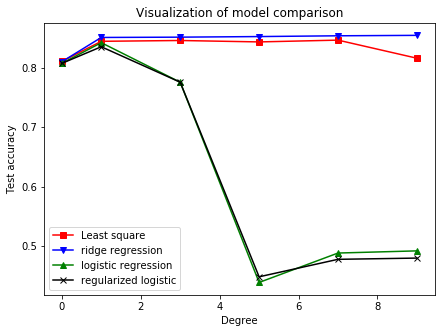

In [54]:
degrees = np.array([0,1,3,5,7,9])

figure,bx = plt.subplots(1,1,figsize = (7,5))
bx.set_title('Visualization of model comparison')
bx.set_xlabel('Degree')
bx.set_ylabel('Test accuracy')
bx.plot(degrees, acc_te_ls, color='r', marker='s', label="Least square" )
bx.plot(degrees, acc_te_rid, color='b', marker='v', label="ridge regression" )
bx.plot(degrees, acc_te_log, color='g', marker='^', label="logistic regression" )
bx.plot(degrees, acc_te_reg, color='#000000', marker='x', label="regularized logistic" )
bx.legend()
figure.savefig('ModelComparison.jpg')

### Further discussion on correlation features

In `2.4.3 Drop features with strong linear correlation` part we mentioned that we decided not to drop linear correlated features because it did not improve much the performance but even made things worse. And in this part, we showed how it affected the model performance and discussed why.

In [37]:
# ridge regression with dropping correlated features
x = df_tr_grp_dpcorr[0].drop('Prediction').values

y = df_tr_grp_dpcorr[0]['Prediction']
y = y.reshape(len(y),1)
k_fold = 10
seed = 10

lambda_ = 0.001
regression_method = ridge_regression
acc_tr_dpcorr = np.zeros((6,1))
acc_te_dpcorr = np.zeros((6,1))
w_rid,acc_tr_dpcorr[0],acc_te_dpcorr[0] = cv_loop(y, x, k_fold, seed, regression_method,lambda_=lambda_)
print("Degree: 0, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(acc_tr=acc_tr_dpcorr[0], 
                                                                                                acc_te=acc_te_dpcorr[0]))

degrees = [1,3,5,7,9]

for i in range(len(degrees)):
    tx = data_processing(x,degrees[i])
    w_rid,acc_tr_dpcorr[i+1],acc_te_dpcorr[i+1] = cv_loop(y, tx, k_fold, seed, regression_method,lambda_=lambda_)
    print("Degree: {deg}, the 10-fold average train accuracy = {acc_tr}, test accuracy={acc_te}".format(deg=str(degrees[i]),
                                                                                                        acc_tr=acc_tr_dpcorr[i+1], acc_te=acc_te_dpcorr[i+1]))


Degree: 0, the 10-fold average train accuracy = [0.810389], test accuracy=[0.81064958]
Degree: 1, the 10-fold average train accuracy = [0.84377683], test accuracy=[0.8432189]
Degree: 3, the 10-fold average train accuracy = [0.84499121], test accuracy=[0.84422981]
Degree: 5, the 10-fold average train accuracy = [0.84608772], test accuracy=[0.84545091]
Degree: 7, the 10-fold average train accuracy = [0.84729543], test accuracy=[0.84687218]
Degree: 9, the 10-fold average train accuracy = [0.8477436], test accuracy=[0.84719247]


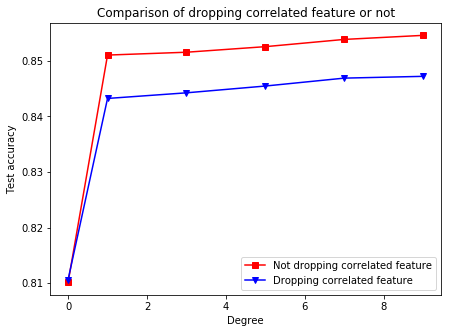

In [51]:
degrees = np.array([0,1,3,5,7,9])

figure2,bx2 = plt.subplots(1,1,figsize = (7,5))
bx2.set_title('Comparison of dropping correlated feature or not')
bx2.set_xlabel('Degree')
bx2.set_ylabel('Test accuracy')
bx2.plot(degrees, acc_te_rid, color='r', marker='s', label="Not dropping correlated feature")
bx2.plot(degrees, acc_te_dpcorr, color='b', marker='v', label="Dropping correlated feature" )
bx2.legend()
figure2.savefig('CorrelatedFeature.jpg')

We can see that when polynomial degree = 0, dropping correlated feature did not improve much performance. On the contrary, when degree grew, although the test accuracy also grew, there was a gap between not dropping and dropping features. The reason may be that after polynomial, some correlated features became non-linear related and may have new physical meaning. Dropping them would lose polynomial information. In the end, we decided to preserve these correlation features.

# Hyperparameter Tuning Using Grid Search

After loading data and selecting features, we could start parameter tuning on polynomial degree and lambda for ridge regression. Grid search is an exhaustive searching method, which tries every possible combination of parameters and find the combination of best performation. Here we defined functions `grid_serach` and `ridge_grid_search` to implement grid search and function `get_best_parameters` to return best parameters based on test set accuracy.

In [56]:
def get_best_parameters(para1,para2, acc):
    """
    Get the best degree and lambda from the result of grid search.
    
    Inputs:
        para1,para2:
        Range of parameters in numpy.array.
        
        acc:
        Accuracy matrix saving the accuracy of each 
    
    """
    max_row, max_col = np.unravel_index(np.argmax(acc), acc.shape)
    return acc[max_row, max_col], para1[max_row], para2[max_col]

In [62]:
def grid_search(y, tx, method, para1, para2):
    """
    Function implements grid search.
    
    Inputs:
        y,tx:
        Label and data for model training.
        
        para1,para2:
        Range of parameters in numpy.array.
    
    Result:
        acc_tr,acc_te:
        Average accuracy of 10-fold cross validation for training set and test set.
    """
    acc_tr = np.zeros((len(para1), len(para2)))
    acc_te = np.zeros((len(para1), len(para2)))
    for i in range(0,len(para1)):
        for j in range(0,len(para2)):
            tx_poly = data_processing(tx,para1[i])
            lambda_ = para2[j]
            _,acc_tr[i][j],acc_te[i][j] = cv_loop(y=y, x=tx_poly, k_fold=3, seed=10, regression_method=method, lambda_=lambda_)
    return acc_tr,acc_te

In [63]:
def ridge_grid_search(data,pred,degrees,lambdas):
    """
    The function is used for hyper parameter tuning for ridge regression using grid search.
    
    Inputs:
        degrees: 
        Numpy.array. Degrees range for grid search.
        
        lambdas: 
        Numpy.array. Lambdas range for grid search.
        
    Return:
        The average accuracy of 10-fold cross validation of training set and test set.
    """
    acc_tr = []
    acc_te = []
    for i in range(len(data)):
        tx = data[i]
        y = pred[i]
        acc_tr_tmp,acc_te_tmp = grid_search(y,tx,ridge_regression,degrees,lambdas)
        acc_tr.append(acc_tr_tmp)
        acc_te.append(acc_te_tmp)
    return acc_tr,acc_te

We set the degrees from 1 to 14, and lambdas = 0.0005,0.001,0.01,0.1, then we ran ridge regression exhaustively using every possible combination of degree and lambdas.

In [64]:
degrees = np.arange(14)+1
lambdas = [0.0005,0.001,0.01,0.1]
acc_tr_grid,acc_te_grid = ridge_grid_search(data_tr_grp,pred_tr_grp,degrees,lambdas)

In [65]:
def plot_gridsearch(acc_tr,acc_te,degrees,lambdas):
    """
    This function is used to plot the result of grid search on accuracy over different values of hyper parameters.
    
    Inputs:
        acc_tr,acc_te: 
        The average accuracy of 10-fold cross validation of training set and test set.
        
        degrees,lambdas:
        Numpy.array. Degrees and lambdas range for grid search.
    """
    fig,ax = plt.subplots(3,4,figsize = (30,30))
    ax = ax.ravel()
    idx = 0

    for j in range(len(acc_tr)):
        for i in range(acc_tr[0].shape[1]):
            ax[idx].plot(degrees, acc_tr[j][:,i], color='r', marker='s', label="Train Accuray" )
            ax[idx].plot(degrees, acc_te[j][:,i], color='b', marker='v', label="Test Accuracy" )
            ax[idx].plot(degrees, (acc_te[j][:,i]+acc_tr[j][:,i])/2, color='g', marker='^', label="Average Accuracy" )
            ax[idx].set_title('Lambda = '+str(lambdas[i]))
            ax[idx].set_xlabel('Degree',size=15)
            ax[idx].set_ylabel('Accuracy',size=15)
            ax[idx].legend()
            idx = idx + 1
        acc,degree,lambda_ = get_best_parameters(degrees,lambdas, acc_te[j])
        print("For group jet_num = {j}, best test accuracy={acc}, poly degree={degree}, lambda={lambda_}".format(j = j,acc=acc, degree=degree, lambda_ = lambda_))
    fig.suptitle('Grid Search Result over Polynomial Degree and Lambda',size=30,y=0.93)
    fig.text(0.5, 0.9, 'Group jet_num = 0', ha='center', va='center',size = 25)
    fig.text(0.5, 0.63, 'Group jet_num = 1', ha='center', va='center',size = 25)
    fig.text(0.5, 0.35, 'Group jet_num = 2,3', ha='center', va='center',size = 25)
    fig.subplots_adjust(hspace=.5)
    fig.savefig('GridSearchRidge.jpg')

From the plotting below we could see how the accuracy on test set changes according to the change of degree and lambda. Red line with square point was training accuracy, blue line with down triangle point was testing accuracy and the green line with up triangle point was the average accuracy of training and testing.

The `plot_gridsearch` also returned the parameter combination of best test set accuracy. And we noticed that the highest accuracy under lambda = 0.001 was very close to that of lambda = 0.0005. So, to avoid overfitting we decided to use higher `lambda = 0.001`, and choose the `degree = 11, 10, 11` respectively for each group as the best parameters.

For group jet_num = 0, best test accuracy=0.85451197053407, poly degree=10, lambda=0.0005
For group jet_num = 1, best test accuracy=0.8196894666253999, poly degree=10, lambda=0.001
For group jet_num = 2, best test accuracy=0.8507781591607735, poly degree=11, lambda=0.0005


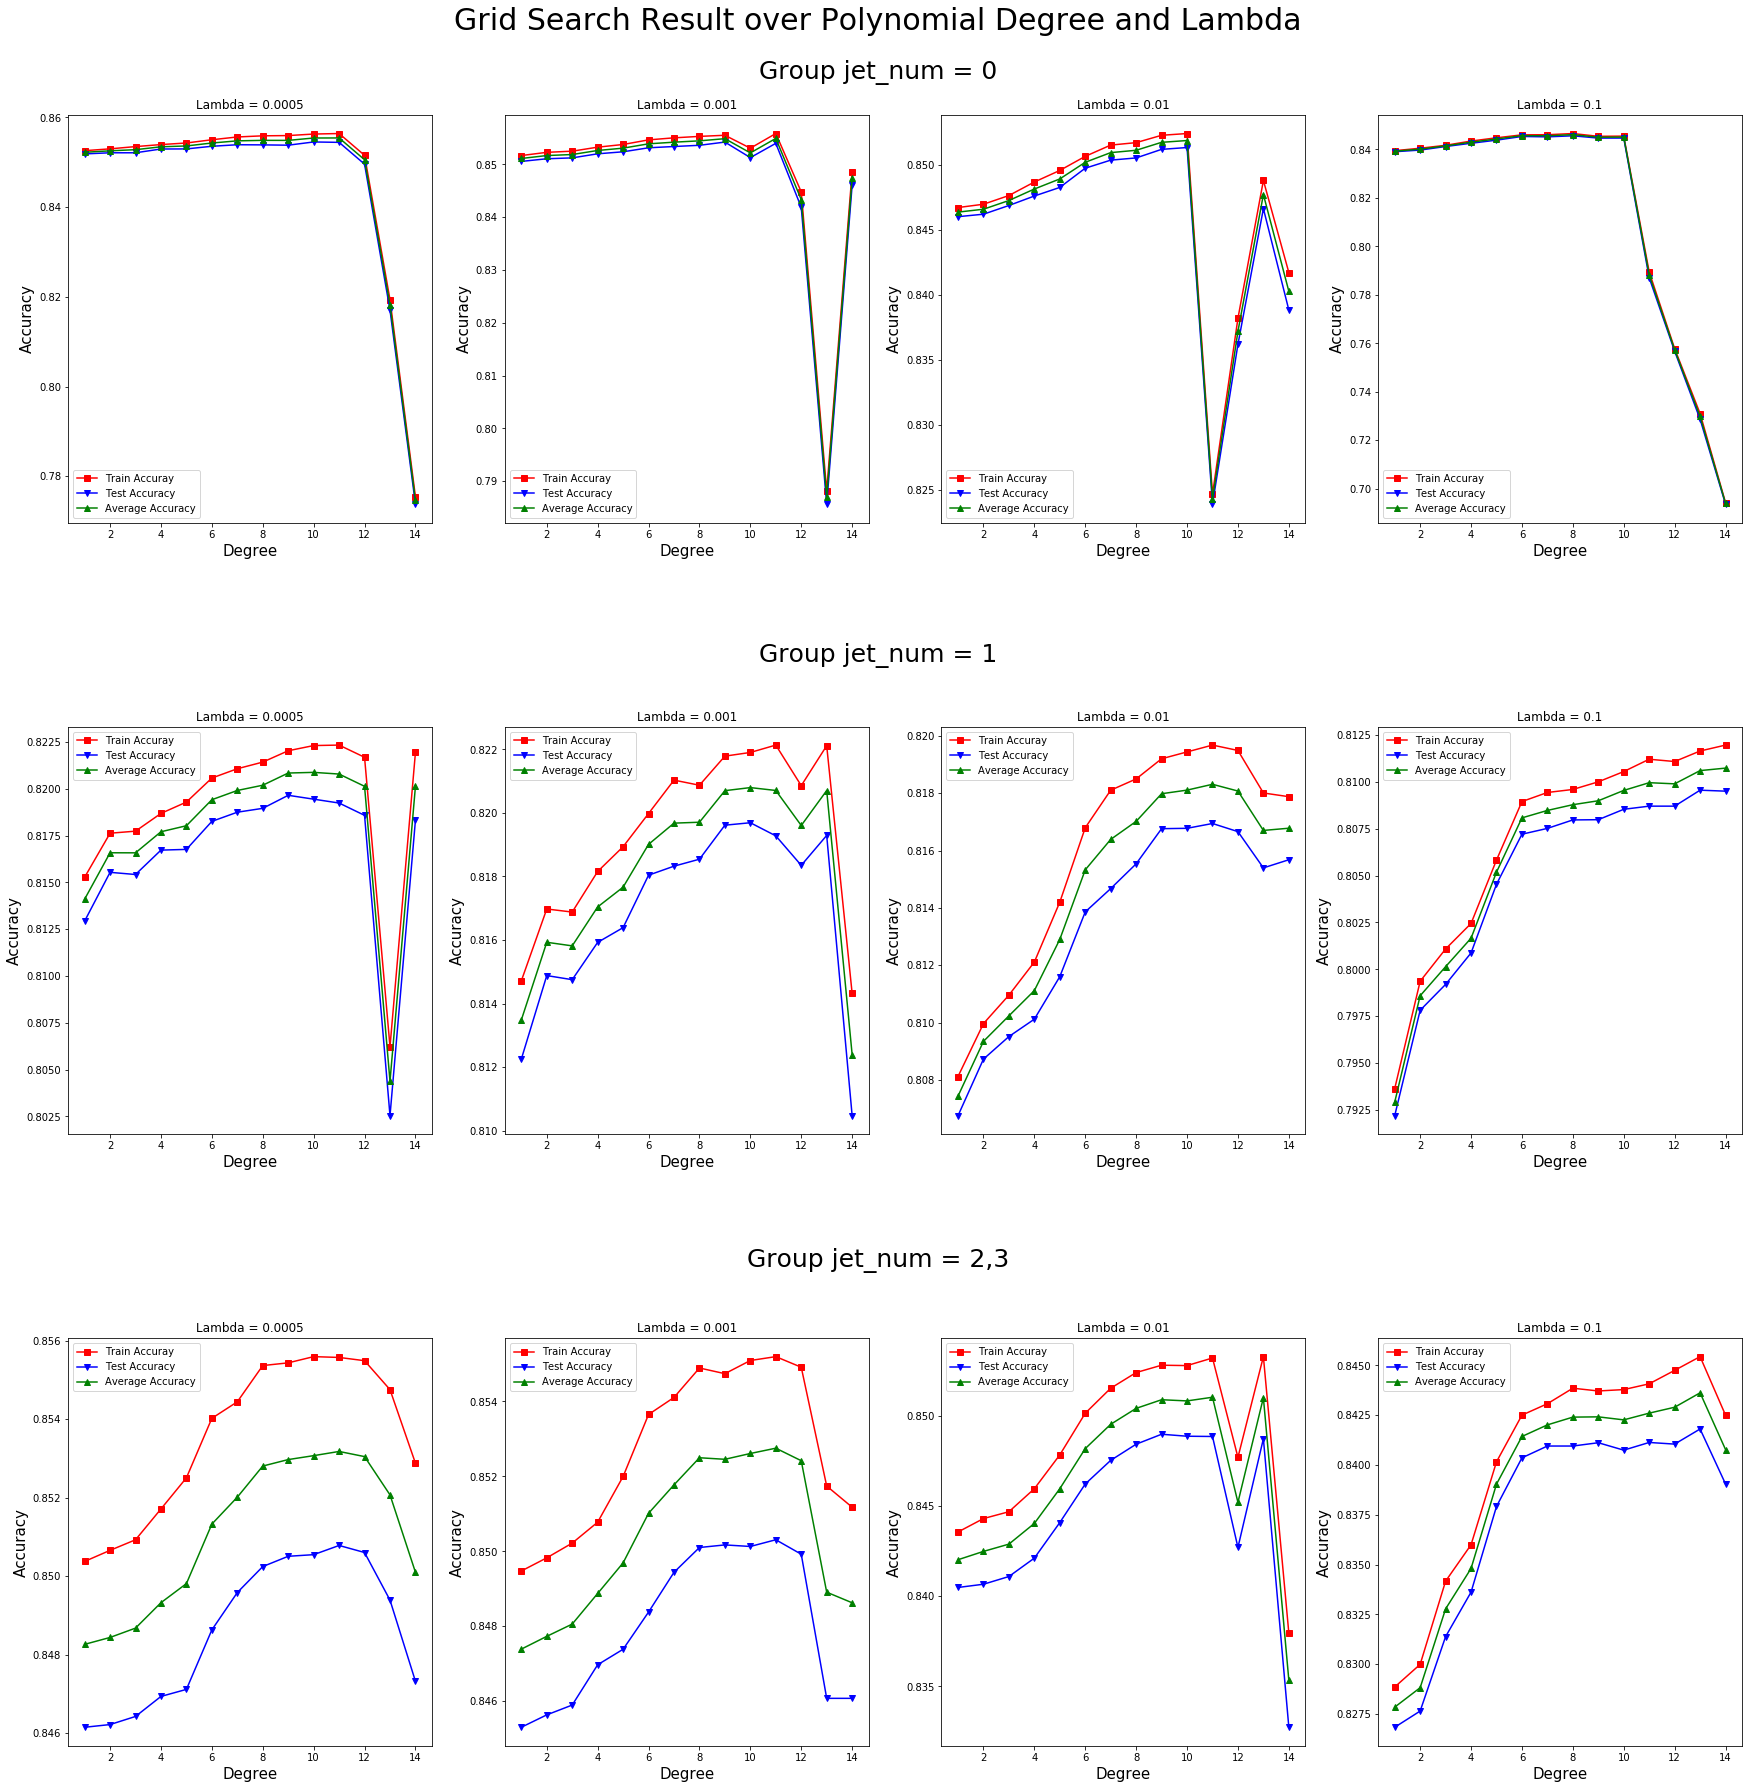

In [66]:
plot_gridsearch(acc_tr_grid,acc_te_grid,degrees,lambdas)

# Results of ridge regression

Here we show the result of ridge regression using best parameter calculated from grid search.


In [ ]:
lambda_ = 0.001
degrees = [11,10,11]
k_fold = 10
seed = 10
y_te = []
w = []
for i in range(len(data_tr_grp)):
    # model training
    x = data_tr_grp[i]
    x_tr = data_processing(x,degrees[i])
    y_tr = pred_tr_grp[i]
    w_tmp, _, _ = cv_loop(y_tr, x_tr, k_fold , seed, ridge_regression, lambda_=lambda_)
    w.append(w_tmp)
    # test model
    x = data_te_grp[i]
    x = log_process(x)
    x, _, _ = standardize(x)
    x_te = build_poly(x, degrees[i])
    y_te.append(predict_labels(w[i], x_te))
    
y_pred_te = np.concatenate((y_te[0],y_te[1],y_te[2]))
idx_te = np.concatenate((pred_te_grp[0], pred_te_grp[1], pred_te_grp[2]))

In [ ]:
create_csv_submission(idx_te, y_pred_te, 'ridge_11_10_11.csv')